In [63]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import load_npz

import torch

import utils

In [2]:
_A_obs = load_npz('../data/datasets/CORA_ML.npz')

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Get true transition matrix, true logits matrix, synthetic transition matrix and synthetic logits matrix

In [34]:
P = train_graph.toarray() / np.array(train_graph.sum(axis=-1))
P_logits = np.log(P + 1e-9) # Need small offset to avoid log(0)

In [35]:
# Test if P_logits is equal to P after softmax is applied
np.linalg.norm(P-torch.nn.functional.softmax(torch.tensor(P_logits), dim=-1).numpy())

9.694150647238772e-05

In [59]:
weights = np.load('../logs/CORA-ML/Ours/Experiment_0/weights/weights_36.npz')
Wdown, Wup = weights['W_down'], weights['W_up']

P_logits_synth = Wdown @ Wup
P_synth = torch.nn.functional.softmax(torch.tensor(P_logits_synth), dim=-1).numpy()

In [147]:
def get_descending_eigenvalues(dict_of_matrices):
    dict_of_eigvals = dict_of_matrices
    for name, matrix in dict_of_matrices.items():
        eigvals = np.real(np.linalg.eig(matrix)[0])
        eigvals = np.sort(np.abs(eigvals))[::-1]
        dict_of_eigvals[name] = eigvals
    return dict_of_eigvals

def plot_eigenvalues(dict_of_eigvals, formats, save_path=None):
    f, axs = plt.subplots(figsize=(12, 12))
    for name, eigvals in dict_of_eigvals.items():
        marker, c, zorder = formats[name]
        eigvals /= max(eigvals)
        if marker=='o':
            axs.scatter(np.arange(len(eigvals)), eigvals, s=10, marker=marker, facecolors='None', 
                        zorder=zorder,
                        edgecolors=c, 
                        label=name)
        else:
            axs.scatter(np.arange(len(eigvals)), eigvals, s=10, marker=marker, c=c, 
                        zorder=zorder, 
                        label=name)
    f.legend(loc='upper right', bbox_to_anchor=(0.75, 0.75), fontsize=20, markerscale=3)
    if save_path:
        plt.savefig(fname=save_path, bbox_inches='tight')     
    plt.show()
    return

In [86]:
dict_of_matrices = {'P':P, 'P_logits':P_logits, 'P_synth':P_synth, 'P_logits_synth':P_logits_synth}
dict_of_eigvals = get_descending_eigenvalues(dict_of_matrices)

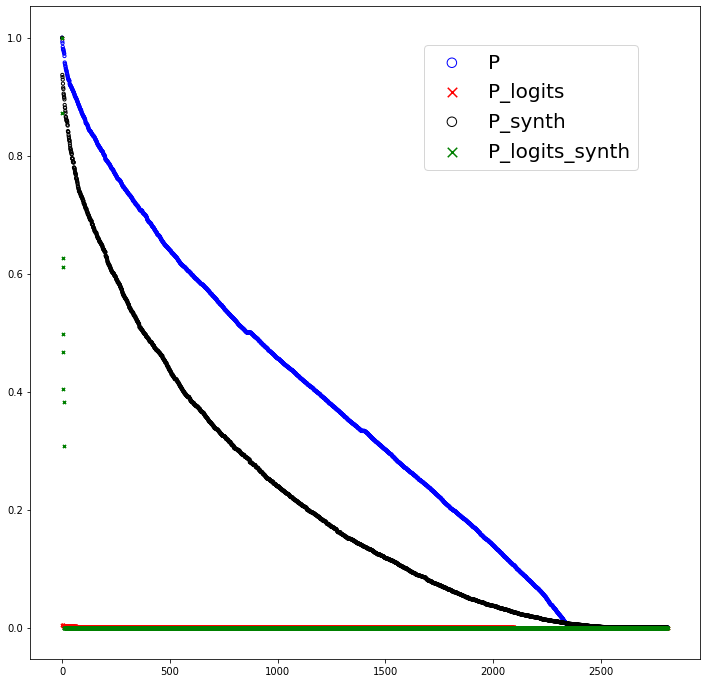

In [150]:
formats = {'P': ('o', 'b', 0), 'P_logits':('x', 'r', 0), 'P_synth':('o', 'k', 0), 'P_logits_synth':('x', 'g', 10)}
plot_eigenvalues(dict_of_eigvals, formats, save_path='../fig/eigenvalues.pdf')

In [88]:
dict_of_eigvals['P_logits'][:10]

array([58142.49480013,   281.68933756,   268.23464351,   249.49001058,
         208.97677085,   182.32426763,   181.73687861,   181.70926986,
         175.10307312,   166.784529  ])